**这部分的代码将：**

1.读取转换后的数据

2.使用训练集对模型进行训练（训练n个平行模型）

3.测试模型并输出结果

#### 0.载入包和初始化

In [2]:
import pandas as pd
import random
import ast
import csv
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import ptitprince as pt

import os 
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

device =torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('using gpu: %s' % torch.cuda.is_available())
isgpu = torch.cuda.is_available()

C:\Users\Sengoku\AppData\Local\Temp\ipykernel_35328\1599187777.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


using gpu: True


#### 1.读取数据

In [3]:
#读取训练集和测试集
x_set = []
y_set = []
trail_set =[]
trail_set_test =[]
root_path = 'C:/GitHub/FSNet/1.code/data'
df_test_raw = pd.read_csv(root_path + '/fs_human_test_raw.csv',header=0)

df = pd.read_csv(root_path + '/output_fs_human.csv')
for index , row in df.iterrows():
    list_x = ast.literal_eval(row[0])
    list_y = ast.literal_eval(row[1])
    trail_set.append((list_x,list_y))  
df_test = pd.read_csv(root_path + '/output_fs_human_test.csv')
for index , row in df.iterrows():
    list_x = ast.literal_eval(row[0])
    list_y = ast.literal_eval(row[1])
    trail_set_test.append((list_x,list_y))   

C:\Users\Sengoku\AppData\Local\Temp\ipykernel_35328\1595825106.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  list_x = ast.literal_eval(row[0])
C:\Users\Sengoku\AppData\Local\Temp\ipykernel_35328\1595825106.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  list_y = ast.literal_eval(row[1])
C:\Users\Sengoku\AppData\Local\Temp\ipykernel_35328\1595825106.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  list_x = ast.literal

#### 2.训练模型

In [4]:
train_num = 40 #定义了训练多少个平行模型

thresholds = 0.8 #作出选择的阈值
check_point = 21 #作出选择的检查点

loss_ther = 0.035 #停止训练的loss阈值

train_correct_list = []
train_sk_list = []
train_fs_list = []
train_match_list = []
train_mis_list = []
train_rt_list = []

human_mean =564 #训练集人类平均反应时间
human_std =139 #训练集人类反应时间标准差

out_put_raw = []
match_raw = []

In [5]:
response_trail = []
for train_i in range(train_num):
    # 定义模型
    class rnnNet(nn.Module):
        def __init__(self):
            super(rnnNet, self).__init__()
            self.rnn = nn.RNN(input_size = 2, hidden_size = 32,num_layers = 1,batch_first = True, nonlinearity='relu')
            for name, param in self.rnn.named_parameters():
                if name.startswith("weight"):
                    nn.init.xavier_normal_(param)
                else:
                    nn.init.zeros_(param)

            self.fc = nn.Linear(32,2)
            self.relu = nn.ReLU()  

        def forward(self, x):
            out, h = self.rnn(x, None)
            out = self.relu(out)
            out = self.fc(out)
            return out
    model = rnnNet().to(device)
    # torch.save(model, 'model_start_'+str(train_i)+'.pth')
    
    # 训练模型
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00025) 
    running_loss = 0
    u = 0.5
    sigma = 0.1
    total = 0
    loss_report = 200
    loss_list = []
    stimulus_num = len(x_set)
    i = 0

    num_epochs = 500
    avg_loss = 1
    min_loss = 1

    for epoch in range(num_epochs):
        if avg_loss < loss_ther:
            print('break')
            break

        for trail in enumerate(trail_set):
            input_stimul = torch.tensor(trail[1][0])
            # input_mask = torch.tensor(trail[1][2])
            labels = torch.tensor(trail[1][1])        
            optimizer.zero_grad()
            input_channel = input_stimul
            outputs = model(input_channel.to(device))

            loss = criterion(outputs,labels.to(device))
            loss.backward()
            optimizer.step()
            
            running_loss +=loss.item()
            total +=running_loss
            i +=1
            if i %loss_report == 0:
                avg_loss = float(total/loss_report)
                print("step[{}]  loss:{:.4f}".format(i+1,avg_loss))
                loss_list.append(avg_loss)
                total = 0
                if avg_loss < min_loss:
                    min_loss = avg_loss
                if avg_loss < loss_ther:
                    print('loss reach the thereshold')
                    break
            running_loss = 0

    # torch.save(model, 'model_weights_'+str(train_i)+'.pth')
    
    # 测试模型
    correct = 0
    num = 0
    match_timelist = []
    mismatch_timelist = []
    choice = 0
    react_timepoint = 0
    label_rt = []
    output_rt = []
    
    i = 0
    for trail in enumerate(trail_set_test):
        input_stimul = torch.tensor(trail[1][0])
        labels = torch.tensor(trail[1][1])
        input_channel = input_stimul  
        if i == 72:
            break
        i +=1

        outputs = model(input_channel.to(device))

        outputs_number = outputs.cpu().detach().numpy()
        labels_number = labels.cpu().detach().numpy()
        
        out_put_raw.append(outputs_number)
        match_raw.append(labels_number)
        
        # for j in range(len(outputs_number)):
        #     if (outputs_number[j][0] > thresholds):
        #         react_timepoint = j-1+(thresholds-outputs_number[j-1][0])/(outputs_number[j][0]-outputs_number[j-1][0])
        #         #mis
        #         plt.plot(outputs_number, color = 'blue',alpha = 0.001)
        #         mismatch_timelist.append(react_timepoint)
        #         choice = 0
        #         break
        #     if (outputs_number[j][1] > thresholds):
        #         react_timepoint = j-1+(thresholds-outputs_number[j-1][1])/(outputs_number[j][1]-outputs_number[j-1][1])
        #         #match
        #         plt.plot(outputs_number, color = 'red',alpha = 0.001)
        #         match_timelist.append(react_timepoint)
        #         choice = 1
        #         break
        # plt.plot(labels_number, color = 'black',alpha = 0.001)
        # output_rt.append(react_timepoint)
        
        # react_time = ((float(react_timepoint) - 14.3) / 0.9 * human_std) + human_mean
        # react_time = (react_timepoint - 7)*100
        # response_trail.append((train_i,react_time,choice,1))
        
        # num +=1
        # if choice == labels[check_point][1]:
        #     correct+=1

    # print(sum(match_timelist) / len(match_timelist))
    # print(sum(mismatch_timelist) / len(mismatch_timelist))
    # print(correct/num)

    # plt.show()  
    #求output的mean和std 把output标准化
    # mean = np.mean(output_rt)
    # std = np.std(output_rt)
    # # print(mean,std)
    # output_rt_normalized = (output_rt - mean) / std
    # output_rt_humanized = (output_rt_normalized * human_std) + human_mean
    # # plt.hist(output_rt_humanized,bins = 30) 
    # match_timelist_nor = (match_timelist - mean) / std
    # match_timelist = (match_timelist_nor * human_std) + human_mean
    # mismatch_timelist_nor = (mismatch_timelist - mean) / std
    # mismatch_timelist = (mismatch_timelist_nor * human_std) + human_mean
    
    
    
    # mean = np.mean(output_rt)
    # std_dev = np.std(output_rt)
    # # 计算偏度
    # skewness = np.mean(((output_rt - mean) / std_dev) ** 3)
    # # print("Skewness:", skewness)
    # match_mean = (sum(match_timelist) / len(match_timelist))
    # mismatch_mean = (sum(mismatch_timelist) / len(mismatch_timelist))

    # # train_fs_list.append(match_mean/mismatch_mean)
    # train_correct_list.append(correct/num)
    # train_sk_list.append(skewness)
    # train_match_list.append(match_mean)
    # train_mis_list.append(mismatch_mean)
    
plt.show()

step[201]  loss:0.1483
step[401]  loss:0.1109
step[601]  loss:0.1089
step[801]  loss:0.1081
step[1001]  loss:0.1068
step[1201]  loss:0.1077
step[1401]  loss:0.1082
step[1601]  loss:0.1037
step[1801]  loss:0.1062
step[2001]  loss:0.1027
step[2201]  loss:0.1040
step[2401]  loss:0.1045
step[2601]  loss:0.1011
step[2801]  loss:0.0999
step[3001]  loss:0.0825
step[3201]  loss:0.0578
step[3401]  loss:0.0449
step[3601]  loss:0.0463
step[3801]  loss:0.0604
step[4001]  loss:0.0523
step[4201]  loss:0.0530
step[4401]  loss:0.0498
step[4601]  loss:0.0488
step[4801]  loss:0.0491
step[5001]  loss:0.0485
step[5201]  loss:0.0473
step[5401]  loss:0.0516
step[5601]  loss:0.0378
step[5801]  loss:0.0391
step[6001]  loss:0.0433
step[6201]  loss:0.0425
step[6401]  loss:0.0558
step[6601]  loss:0.0524
step[6801]  loss:0.0439
step[7001]  loss:0.0474
step[7201]  loss:0.0521
step[7401]  loss:0.0416
step[7601]  loss:0.0461
step[7801]  loss:0.0482
step[8001]  loss:0.0440
step[8201]  loss:0.0502
step[8401]  loss:0.0

##### 根据模型输出的反应曲线来计算 选择和反应时

In [6]:
thresholds = 0.9

correct = 0
num = 0
match_timelist = []
mismatch_timelist = []
choice = 0
react_timepoint = 0
label_rt = []
output_rt = []
response_trail = []
for i in range(len(out_put_raw)):
    outputs_number = out_put_raw[i]
    labels_number = match_raw[i]
    
    for j in range(len(outputs_number)):
            if (outputs_number[j][0] > thresholds):
                react_timepoint = j-1+(thresholds-outputs_number[j-1][0])/(outputs_number[j][0]-outputs_number[j-1][0])
                #mis
                # plt.plot(outputs_number, color = 'blue',alpha = 0.001)
                mismatch_timelist.append(react_timepoint)
                choice = 0
                break
            if (outputs_number[j][1] > thresholds):
                react_timepoint = j-1+(thresholds-outputs_number[j-1][1])/(outputs_number[j][1]-outputs_number[j-1][1])
                #match
                # plt.plot(outputs_number, color = 'red',alpha = 0.001)
                match_timelist.append(react_timepoint)
                choice = 1
                break
            
    output_rt.append(react_timepoint)
    # react_time = (react_timepoint - 7)*100
    react_time = react_timepoint*110 - 1180
    response_trail.append((train_i,react_time,choice,1))

#### 4.测试模型
##### 绘制人类反应测试集的反应时分布和神经网络反应时分布

Text(0, 0.5, 'Human RT')

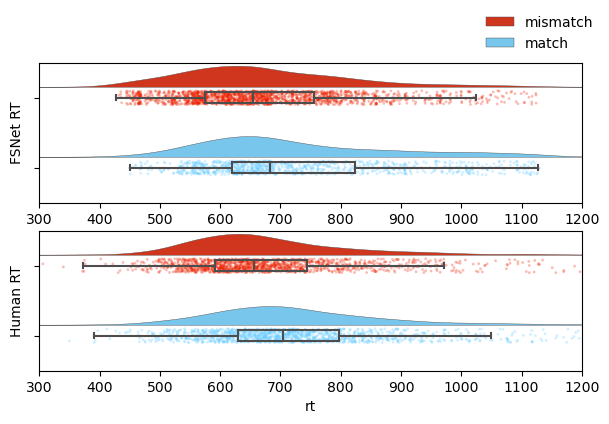

In [7]:
response_trail = pd.DataFrame(response_trail,columns=['model_id','rt','choice','correct'])
colors_palette = ['#ee2100','#66ccff']

plt.figure(figsize = (7,4))
plt.subplot(2, 1, 1)
# f, ax=plt.subplots(figsize=(8, 3))
ax=pt.half_violinplot(y='choice', x='rt', data=response_trail, bw=0.3,
                      cut=5, scale="area", width=.6, inner=None, orient='h',linewidth = 0.3,palette = colors_palette)
ax=sns.stripplot(x='rt', y='choice', data=response_trail, 
                 edgecolor="white", size=2, jitter=1, zorder=0, orient='h',alpha =0.3,palette = colors_palette)
ax=sns.boxplot(x='rt', y='choice', data=response_trail, color="grey", width=.15, zorder=10,
               showcaps=True, boxprops={'facecolor':'none',"zorder":10},
               showfliers=False,
               saturation=1, orient='h')
plt.ylabel("FSNet RT")
plt.xlabel("")
plt.xlim(300,1200)
plt.yticks((0,1),())
plt.legend(["mismatch","match"],bbox_to_anchor=(0.8, 1), frameon=False)

plt.subplot(2, 1, 2)

ax=pt.half_violinplot(y='matchness', x='rt', data=df_test_raw, bw=.2,
                      cut=1., scale="area", width=.6, inner=None, orient='h',linewidth = 0.3,palette = colors_palette)
ax=sns.stripplot(x='rt', y='matchness', data=df_test_raw, 
                 edgecolor="white", size=2, jitter=1, zorder=0, orient='h',alpha =0.3,palette = colors_palette)
ax=sns.boxplot(x='rt', y='matchness', data=df_test_raw, color="grey", width=.15, zorder=10,
               showcaps=True, boxprops={'facecolor':'none',"zorder":10},
               showfliers=False,
               saturation=1, orient='h')
plt.xlim(300,1200)
plt.yticks((0,1),())
plt.ylabel("Human RT")

##### 绘制神经网络反应时在匹配和不匹配上的分布

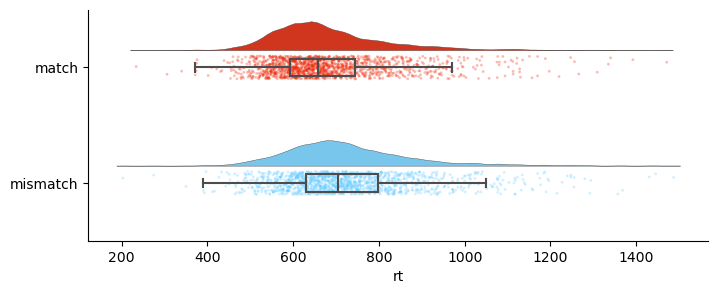

In [8]:
f, ax=plt.subplots(figsize=(8, 3))
ax=pt.half_violinplot(y='matchness', x='rt', data=df_test_raw, bw=.1,
                      cut=1., scale="area", width=.5, inner=None, orient='h',linewidth = 0.3,palette = colors_palette)
ax=sns.stripplot(x='rt', y='matchness', data=df_test_raw, 
                 edgecolor="white", size=2, jitter=1, zorder=0, orient='h',alpha =0.3,palette = colors_palette)
ax=sns.boxplot(x='rt', y='matchness', data=df_test_raw, color="grey", width=.15, zorder=10,
               showcaps=True, boxprops={'facecolor':'none',"zorder":10},
               showfliers=False,
               saturation=1, orient='h')
ax.set_ylabel("")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

##### 绘制人类反应测试集的反应时分布和神经网络反应时分布（全部反应时分布）

(200.0, 1500.0)

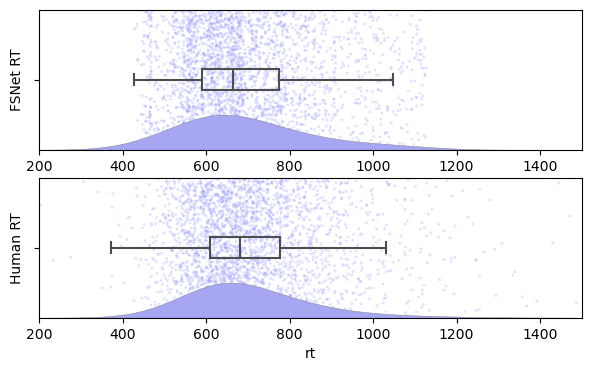

In [9]:
colors_palette = ['','']
plt.figure(figsize = (7,4))
plt.subplot(2, 1, 1)
pt.half_violinplot(x='rt', data=response_trail, bw=.6,
                      cut=3, scale="area", width=.5, inner=None, orient='h',linewidth = 0.3,offset = -0.5, color = '#9999FF')
sns.stripplot(x='rt', data=response_trail, edgecolor="white", size=2, jitter=0.5, zorder=0, orient='h',alpha =0.3, color = '#9999FF')
sns.boxplot(x='rt', data=response_trail, color="grey", width=.15, zorder=10,
               showcaps=True, boxprops={'facecolor':'none',"zorder":10},
               showfliers=False,
               saturation=1, orient='h')
plt.xlim(200,1500)

plt.ylabel("FSNet RT")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.subplot(2, 1, 2)
pt.half_violinplot(x='rt', data=df_test_raw, bw=.5,
                      cut=0., scale="area", width=.5, inner=None, orient='h',linewidth = 0.3,offset = -0.5,color ='#9999FF')
ax=sns.stripplot(x='rt', data=df_test_raw, 
                 edgecolor="white", size=2, jitter=0.5, zorder=0, orient='h',alpha =0.3, color = '#9999FF')
ax=sns.boxplot(x='rt', data=df_test_raw, color="grey", width=.15, zorder=10,
               showcaps=True, boxprops={'facecolor':'none',"zorder":10},
               showfliers=False,
               saturation=1, orient='h')
plt.ylabel("Human RT")
plt.xlim(200,1500)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

##### 统计检验

In [10]:
from scipy import stats

print(np.mean(train_sk_list))

t_statistic, p_value = stats.ttest_ind(train_match_list, train_mis_list, alternative='less')

print("t统计量:", t_statistic)
print("p值:", p_value)

# 根据p值判断是否拒绝原假设
if p_value < 0.01:
    print("match和mismatch的均值有显著差异。")
else:
    print("match和mismatc的均值没有显著差异。")
    
# 进行单样本t检验，检验样本均值是否为0
t_statistic, p_value = stats.ttest_1samp(train_sk_list, 0, alternative='greater')

print("t统计量:", t_statistic)
print("p值:", p_value)

# 根据p值判断是否拒绝原假设
if p_value < 0.01:
    print("我们拒绝原假设，样本均值与0有显著差异。")
else:
    print("我们不能拒绝原假设，样本均值与0没有显著差异。")


nan
t统计量: nan
p值: nan
match和mismatc的均值没有显著差异。
t统计量: nan
p值: nan
我们不能拒绝原假设，样本均值与0没有显著差异。


f:\anaconda3\envs\RTNet\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
f:\anaconda3\envs\RTNet\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [11]:
#将match和mismatch存储到本地
csv = pd.DataFrame({'match':train_match_list,'mismatch':train_mis_list})
csv.to_csv(root_path + '/output_fs_human_train_result.csv',index=False)

In [12]:
#将match和mismatch从本地读取
df = pd.read_csv(root_path + '/output_fs_human_train_result.csv')
train_match_list = df['match'].tolist()
train_mis_list = df['mismatch'].tolist()

In [13]:
#将match和mis的反应时间合并为一个list
train_rt_list = train_match_list + train_mis_list

print(train_sk_list)
print(train_match_list)
print(train_mis_list)
print(train_correct_list)


print(np.mean(train_sk_list))
print(np.mean(train_match_list),np.std(train_match_list))
print(np.mean(train_mis_list),np.std(train_mis_list))
print(np.mean(train_rt_list),np.std(train_rt_list))
print(np.mean(train_correct_list))

# plt.plot(train_correct_list, color = 'blue')
plt.show()


[]
[]
[]
[]
nan
nan nan
nan nan
nan nan
nan


f:\anaconda3\envs\RTNet\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
f:\anaconda3\envs\RTNet\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
f:\anaconda3\envs\RTNet\lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
f:\anaconda3\envs\RTNet\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
f:\anaconda3\envs\RTNet\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
